#**Project Suggestion:** 
#**Predicting stocks prices with social media (Reddit) traffic**

##Introduction:

For centuries, traders have tried to predict stock market trends to maximize their profits. The myth says that even the founder of the Rothschild family gained his fortune by using mail pigeons, which allowed him to be the first in London to know that the British won the Waterloo battle, allowing him to purchase English stocks at low prices.

Stock markets today have become extremely complex and interactive. As a result, it is nearly impossible to predict what will happen. In order to gain fractions on small arbitrages, many companies pay fortunes to place their servers physically close to the market.

We are attempting to reduce the problem of stock price forecasting to an easier one in a small case with specific stocks.

Recently, and especially last year (as a result of the Coronavirus), a new phenomenon has emerged. Millions of small investors rely on social media traffic for their investments in the stock market. There is a small list of stocks called "Meme Stocks", which are especially associated with this phenomenon.
Meme stocks are real stocks, that have gained popularity due some online trend in social media, as if the stock has gone viral like a meme.

Our project aims to predict a daily change in meme stock prices based on traffic on Reddit. Specifically on the r/wallstreetbets page.

We chose to examine three of the top stocks that were in the headlines over the last 2 years: GME (GameStop), AMC (AMC Entertainment) and NOK (Nokia)

### A typical post on a stock in Reddit:
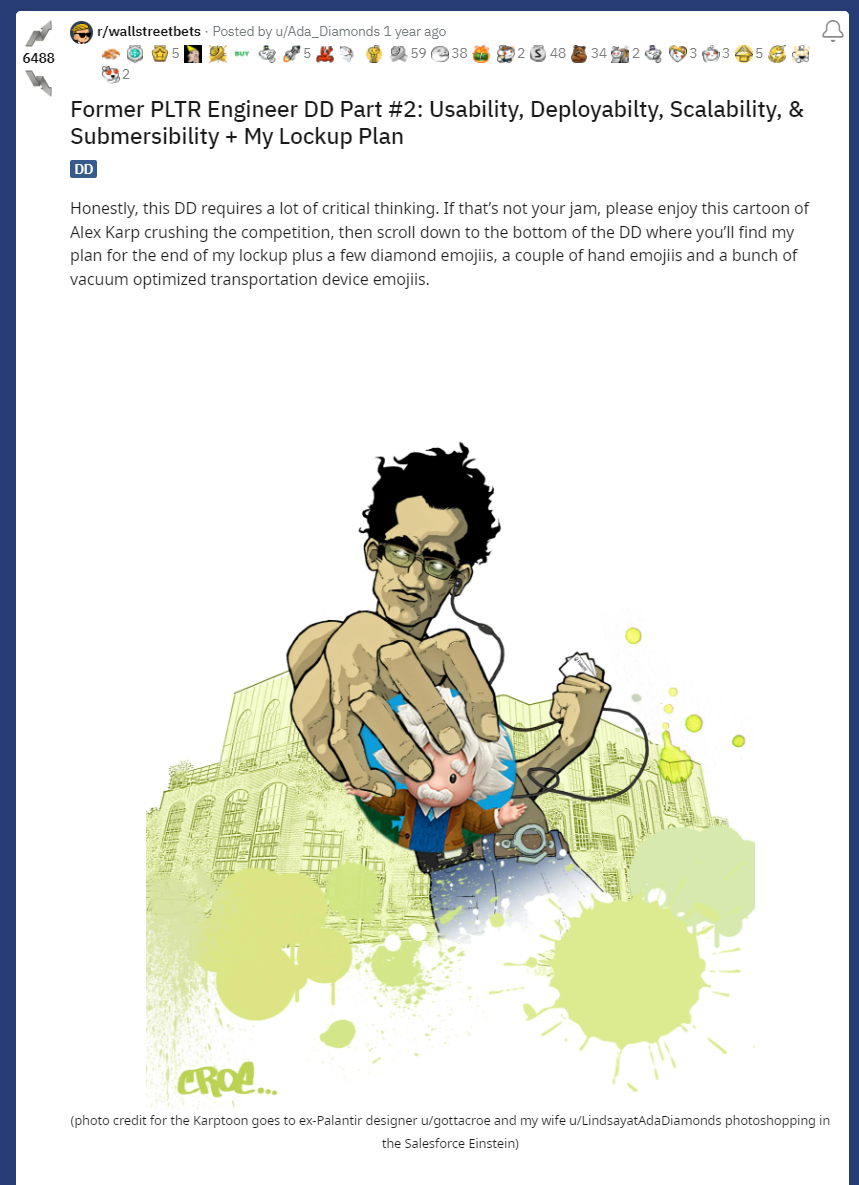

##Imports and aux functions

In [130]:
!pip install prophet
!pip install vaderSentiment


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [208]:
from google.colab import drive
from prophet import Prophet
import gensim
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import statsmodels.api as sm
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.probability import FreqDist
nltk.download('punkt')
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
import warnings
from gensim.models.doc2vec import Doc2Vec
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
import string
from wordcloud import WordCloud
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [132]:
def multy_ROC_curve_one_graph(y_test, y_score, labels ):
  n_class = 2 if len(y_train[y_train == "no change"]) == 0 else 3
  fpr = {}
  tpr = {}
  thresh ={}
  roc_auc = {}
  colors = ['orange', 'green', 'blue','red','purple','brown', 'pink','gray','olive','cyan']
  for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, y_score[:,i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], linestyle='--',color=colors[i],
             label=( '{0}'.format(labels[i])))
  
  plt.plot([0, 1], [0, 1], color="navy", linestyle="-", label='random clf')
  plt.title('Multiclass ROC curve')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive rate')
  plt.legend(loc='best')
  plt.figure(figsize=(8, 6), dpi=80)
  plt.show()   

In [133]:
def get_metrices(y_test, prediction):
  cf_matrix = confusion_matrix(y_test, prediction)
  cl_report = classification_report(y_test, prediction)
  acc_score = accuracy_score(y_test, prediction) * 100
  return cf_matrix, cl_report, acc_score

In [134]:
def plot_confusion_matrix(cf_matrix, title):
  fig, ax = plt.subplots(figsize=(15,10))
  ax = sns.heatmap(cf_matrix, annot=True, linewidths=1, cmap='coolwarm', fmt='g', mask=cf_matrix<1)
  ax.set_facecolor('xkcd:black')
  ax.set(title=title)
  ax.plot()

In [135]:
def roc_curve_PC(clf, X_train, y_train):
  clf = OneVsRestClassifier(clf)
  clf = clf.fit(X_train, y_train)
  y_score =clf.predict_proba(X_test)
  labels=['negative', 'positive', 'no change']
  y_b = y_test.apply(lambda x : 0 if x == 'negative' else 1 if x == 'positive' else 2).values
  multy_ROC_curve_one_graph(y_b, y_score, labels)

In [136]:
def stock_date_show(stock_df, stock_name):
  date_to_show = []
  i = 0
  dates_range = len(stock_df)
  while i<=dates_range:
    date_to_show.append(stock_df['Date'].iloc[i])
    i += int(dates_range/4)
  date_to_show.append(stock_df['Date'].iloc[dates_range-1])
  x = stock_df['Date']
  plt.figure(figsize=(10,4))
  plt.plot(range(len(x)), stock_df['Open'])
  gap = int(dates_range/4)
  plt.xticks(ticks=[0,gap,gap*2,gap*3,gap*4], labels=date_to_show)
  plt.xlabel('Date', fontstyle = 'oblique', fontweight ='bold')
  plt.ylabel('Stock Value', fontstyle = 'oblique', fontweight ='bold')
  plt.title(f'{stock_name} Stock Values', color= 'blue', fontstyle = 'oblique')
  plt.show()

In [137]:
def normialized_sentiment_value_show(df, stock_df, stock_name):
  date_sentiment_df = pd.DataFrame(df.groupby('timestamp', as_index=False).agg({'sentiment': np.sum}))
  date_sentiment_df.rename(columns={'timestamp': 'Date'}, inplace=True)
  normialized_sentiment_value = date_sentiment_df.merge(pd.DataFrame([stock_df['Date'], stock_df['Open']]).T, on = 'Date')
  normialized_sentiment_value.sentiment = normialized_sentiment_value.sentiment.apply(lambda x:
                                                                                          x/normialized_sentiment_value.sentiment.max() if x >=0 
                                                                                          else -x/normialized_sentiment_value.sentiment.min())
  normialized_sentiment_value.Open = normialized_sentiment_value.Open.apply(lambda x: x/normialized_sentiment_value.Open.max())
  date_to_show = []
  dates_range = len(normialized_sentiment_value)
  i = 0
  while i<dates_range:
    date_to_show.append(normialized_sentiment_value['Date'].iloc[i])
    i += int(dates_range/4)
  date_to_show.append(normialized_sentiment_value['Date'].iloc[dates_range-1])
  x = normialized_sentiment_value['Date']
  plt.figure(figsize=(10,4))
  plt.plot(range(len(x)), normialized_sentiment_value['Open'], label='Opening price')
  plt.plot(range(len(x)), normialized_sentiment_value['sentiment'], label='Daily total sentiment')
  plt.legend(loc='lower right')
  gap = int(dates_range/4)
  plt.xticks(ticks=[0,gap,gap*2,gap*3,gap*4], labels=date_to_show)
  plt.xlabel('Date', fontstyle = 'oblique', fontweight ='bold')
  plt.ylabel('Normalized Value', fontstyle = 'oblique', fontweight ='bold')
  plt.title(f'{stock_name} Stock\n Sentiment VS value', color= 'blue', fontstyle = 'oblique')
  plt.show()

In [138]:
# function to calcualte sentiment of post
def sentiment_scores(sentence):
# Create a SentimentIntensityAnalyzer object.
    sid_obj = SentimentIntensityAnalyzer()
# polarity_scores method gives a sentiment dictionary, which contains pos, neg, neu, and compound scores.
    sentiment_dict = sid_obj.polarity_scores(sentence)
    if sentiment_dict['compound'] >= 0.05 :
        return 1
    elif sentiment_dict['compound'] <= - 0.05 :
        return -1
    else :
        return 0

In [139]:
def to_corpus(lines):
  for i, line in enumerate(lines):
    tokens = gensim.utils.simple_preprocess(line)
    yield gensim.models.doc2vec.TaggedDocument(tokens, [i])

In [140]:
def doc2vec(df):
  # functions to add new columns to df- Doc2Vec_title and Doc2Vec_body.
  taggetDoc_title = list(to_corpus(df['title'].to_list()))
  modelD2V_title = gensim.models.doc2vec.Doc2Vec(vector_size=50, min_count=2, epochs=40)
  modelD2V_title.build_vocab(taggetDoc_title)
  modelD2V_title.train(taggetDoc_title, total_examples=modelD2V_title.corpus_count, epochs=modelD2V_title.epochs)
  df['Doc2Vec_title'] = df['title'].apply(lambda x: modelD2V_title.infer_vector(x))
  taggetDoc_body = list(to_corpus(df['body'].dropna().to_list()))
  modelD2V_body = gensim.models.doc2vec.Doc2Vec(vector_size=50, min_count=2, epochs=40)
  modelD2V_body.build_vocab(taggetDoc_body)
  modelD2V_body.train(taggetDoc_body, total_examples=modelD2V_body.corpus_count, epochs=modelD2V_body.epochs)
  df['Doc2Vec_body'] = df['body'].dropna().apply(lambda x: modelD2V_body.infer_vector(x) if x is not None else None )

In [141]:
import warnings
warnings.filterwarnings('ignore')

def create_wordclouds(data_frames):
  for df in data_frames:
    words_df = df[['title','body']]
    words_df['title'] = words_df['title'].str.lower()
    words_df['body'] = words_df['body'].str.lower()
    all_words = pd.concat([words_df['title'].str.split(' '), words_df['body'].str.split(' ')])

    all_words_cleaned = []
    for word in all_words:
      if isinstance(word, float):
        # if no title and no body, it's nan and not iterable
        continue
      text = [x.strip(string.punctuation) for x in word]
      all_words_cleaned.append(text)

    text = [" ".join(text) for text in all_words_cleaned]
    final_text = " ".join(text)

    wordcloud_spam = WordCloud(background_color="white", collocations=False).generate(final_text)
    plt.figure(figsize = (6,6))
    plt.imshow(wordcloud_spam, interpolation='bilinear')
    plt.axis("off")

  plt.show()

##Data Collection:

We leverage an existing corpus of r/wallstreetbets posts available on Kaggle
, consisting of all 44,293 posts from
September 2020 through March 2021

[the dataset from Kaggel](https://www.kaggle.com/datasets/gpreda/reddit-wallstreetsbets-posts)

In [142]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [143]:
posts_df = pd.read_csv('/content/drive/MyDrive/memeStocksData/reddit_wsb.csv')
posts_df.drop(columns=['created','id','url'], inplace=True)
posts_df["timestamp"] = posts_df["timestamp"].str[:10]
posts_day_count = pd.DataFrame(posts_df.groupby('timestamp')['title'].count())
posts_day_count.columns = ["posts_day_count"]
posts_df = posts_df.merge(posts_day_count, left_on="timestamp", right_on="timestamp")


we filtered the data set for posts over 3 specific meme stocks:
####NOK - blackberry, GMA - gamestop, AMC


In [144]:
# Creating posts DF for each stock
GME_posts_df = posts_df[posts_df['title'].str.contains('GME|$GME|gamestop|game stop',case=False) | posts_df['body'].str.contains('GME|$GME|gamestop|game stop',case=False) ]
AMC_posts_df = posts_df[posts_df['title'].str.contains('AMC',case=False) | posts_df['body'].str.contains('AMC',case=False) ]
NOK_posts_df = posts_df[posts_df['title'].str.contains('NOK|nokia',case=False) | posts_df['body'].str.contains('NOK|nokia',case=False)]
print("Columns of every Posts DF: ",list(GME_posts_df.columns))

Columns of every Posts DF:  ['title', 'score', 'comms_num', 'body', 'timestamp', 'posts_day_count']


In [145]:
GME_stocks_df = pd.read_csv('/content/drive/MyDrive/memeStocksData/GME.csv')
NOK_stocks_df = pd.read_csv('/content/drive/MyDrive/memeStocksData/NOK.csv')
AMC_stocks_df = pd.read_csv('/content/drive/MyDrive/memeStocksData/AMC.csv')

In [146]:
# Building the DataFrames (PC stands for price change)
GME_label_df=pd.concat([GME_stocks_df['Date'], pd.DataFrame(GME_stocks_df['Close'] - GME_stocks_df['Open'],columns = ['PC'])], axis = 1)
AMC_label_df=pd.concat([AMC_stocks_df['Date'], pd.DataFrame(AMC_stocks_df['Close'] - AMC_stocks_df['Open'],columns = ['PC'])], axis = 1)
NOK_label_df=pd.concat([NOK_stocks_df['Date'], pd.DataFrame(NOK_stocks_df['Close'] - NOK_stocks_df['Open'],columns = ['PC'])], axis = 1)
GME_df = GME_posts_df.merge(GME_label_df, left_on="timestamp", right_on="Date", how = 'left').drop('Date', 1)
AMC_df = AMC_posts_df.merge(AMC_label_df, left_on="timestamp", right_on="Date", how = 'left').drop('Date', 1)
NOK_df = NOK_posts_df.merge(NOK_label_df, left_on="timestamp", right_on="Date", how = 'left').drop('Date', 1)

####the data frames from Kaggle, filtered by stocks:


In [147]:
GME_df.sample(n=4)

,title,score,comms_num,body,timestamp,posts_day_count,PC
8452,RH to Fidelity... Account closed,62,33,For those of you that made the transfer from R...,2021-02-04,1671,-37.690002
3371,Budding autist here who never invested before....,1,3,Like the title says.,2021-01-29,15694,-54.709991
11975,"Bought GME 26/02 $50c for 💩 and giggles, woke ...",94,18,NaN,2021-02-26,565,-15.720001
2647,"Schwab still allowing GME trades, just bought ...",1,1,Obligatory 💎👐 and 🚀🌕.,2021-01-29,15694,-54.709991


In [148]:
AMC_df.sample(n=4)

,title,score,comms_num,body,timestamp,posts_day_count,PC
5025,PROUD AMC RETARD 10K YOLO INTO 40c,192,27,NaN,2021-05-26,91,1.799999
4559,🚀🚀🚀 ARMY 🚀🚀🚀,71,16,I’m not going to give up posting this!!!\n\nTo...,2021-03-11,554,-0.370000
2981,CNBC,15,0,CNBC currently broadcasting in the U.K. that i...,2021-02-03,2643,0.120000
1980,WeBullIsOverParty,1,0,"As of 25 or so minutes ago from posting, WeBul...",2021-01-29,15694,-1.050000


In [149]:
NOK_df.sample(n=4)

,title,score,comms_num,body,timestamp,posts_day_count,PC
301,what if we all just used cashapp for amc/nok/bb?,3,0,NaN,2021-01-29,15694,-0.57
1506,Forgot to post this screenshot but NOK last we...,44,26,NaN,2021-02-02,1502,-0.21
1409,"People say AMC is a diversion, I say is the fu...",1195,602,https://www.reddit.com/r/wallstreetbets/commen...,2021-01-30,1424,NaN
1590,I am autism💎🤲💎🤲,48,2,I’ve decided that I’m never selling I will be ...,2021-02-04,1671,-0.12


###preprocessing the data:

we used some NLP technics that later be used to forecast price changes by the models


adding
####VADER- text sentiment analysis
and 
####Doc2Vec - bag of words for a post

In [150]:
try:
  # save time of apply func if already calculated
  GME_df = pd.read_pickle('/content/drive/MyDrive/memeStocksData/GME_df_with_sentiment.pkl')
  AMC_df = pd.read_pickle('/content/drive/MyDrive/memeStocksData/AMC_df_with_sentiment.pkl')
  NOK_df = pd.read_pickle('/content/drive/MyDrive/memeStocksData/NOK_df_with_sentiment.pkl')
except:
  GME_df['sentiment'] = GME_df['title'].apply(sentiment_scores)
  AMC_df['sentiment'] = AMC_df['title'].apply(sentiment_scores)
  NOK_df['sentiment'] = NOK_df['title'].apply(sentiment_scores)
  doc2vec(GME_df)
  doc2vec(AMC_df)
  doc2vec(NOK_df)
  GME_df.to_pickle(path='/content/drive/MyDrive/memeStocksData/GME_df_with_sentiment.pkl')
  AMC_df.to_pickle(path='/content/drive/MyDrive/memeStocksData/AMC_df_with_sentiment.pkl')
  NOK_df.to_pickle(path='/content/drive/MyDrive/memeStocksData/NOK_df_with_sentiment.pkl')
GME_df.name = 'GME'
AMC_df.name = 'AMC'
NOK_df.name = 'NOK'

Columns 'Doc2Vec_title' and 'Doc2Vec_body' added to the DF:

In [151]:
GME_df.sample(n=3)

,title,score,comms_num,body,timestamp,posts_day_count,PC,sentiment,Doc2Vec_title,Doc2Vec_body
14422,I Followed The Smart Money with Jon and Pete N...,370,107,I'm a fairly experienced trader..but I felt li...,2021-04-28,84,6.479996,1,"[-0.001257688, -0.0064329547, 0.008508459, -0....","[0.007437843, -0.006095961, 0.0006501113, -0.0..."
5012,$SQ the only app based stock trading still let...,55,11,Should we be moving off RobinHood and into Squ...,2021-01-29,15694,-54.709991,0,"[-0.0038436651, 0.008744218, -0.0045247567, -0...","[-0.0051514227, 0.00014378552, -0.0014011293, ..."
15033,Why Zillow is pulling back after posting their...,48,58,"RDFN and ZG compete on Zs IMT segment, which i...",2021-08-06,84,-2.819992,1,"[-0.0018647375, -0.00017091658, 0.0008581136, ...","[-0.0037462283, 0.009717653, -0.00019495905, -..."


In [152]:
#@title Union df
union_df = pd.concat([GME_df.assign(stock_name="GME"), AMC_df.assign(stock_name="AMC"), NOK_df.assign(stock_name="NOK")])
stocks_df_list = [GME_df, AMC_df, NOK_df]


###Data frames per day

In our project, the question is whether we can predict the value of the stock tomorrow based on the stock history data (yesterday posts, for example). For that, we need to look at the data also from the perspective of days, so we create for each stock additional data frame aggregated by days.

In [153]:
# GME
day_GME_df = GME_df.groupby('timestamp', as_index=False).sum()
y = GME_df.groupby('timestamp', as_index=False)[['posts_day_count','PC']].count().drop(columns='timestamp')
day_GME_df[['posts_day_count','PC']] = day_GME_df[['posts_day_count','PC']].div(y)
day_GME_df.name = GME_df.name

# AMC
day_AMC_df = AMC_df.groupby('timestamp', as_index=False).sum()
y = GME_df.groupby('timestamp', as_index=False)[['posts_day_count','PC']].count().drop(columns='timestamp')
day_AMC_df[['posts_day_count','PC']] = day_AMC_df[['posts_day_count','PC']].div(y)
day_AMC_df.name = AMC_df.name

# NOK
day_NOK_df = NOK_df.groupby('timestamp', as_index=False).sum()
y = GME_df.groupby('timestamp', as_index=False)[['posts_day_count','PC']].count().drop(columns='timestamp')
day_NOK_df[['posts_day_count','PC']] = day_NOK_df[['posts_day_count','PC']].div(y)
day_NOK_df.name = NOK_df.name

#Union day_df of all stocks:
union_day_df = pd.concat([day_GME_df.assign(stock_name="GME"), day_AMC_df.assign(stock_name="AMC"), day_NOK_df.assign(stock_name="NOK")])

# for GME we create also a "day before" df
day_before = day_GME_df
day_before['PC']  = day_before['PC'].shift(-1)
day_before.sample(n=3)

,timestamp,score,comms_num,posts_day_count,PC,sentiment
28,2021-02-25,366253,181849,545.0,-15.720001,4
77,2021-04-15,65349,29080,83.0,-1.309998,4
101,2021-05-12,6610,1090,92.0,17.059998,0


##Exploratory Data Analysis

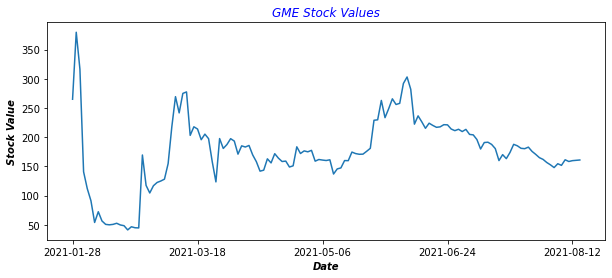

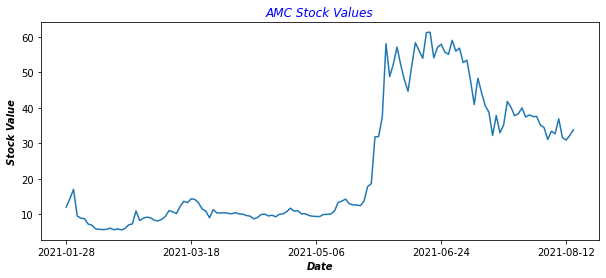

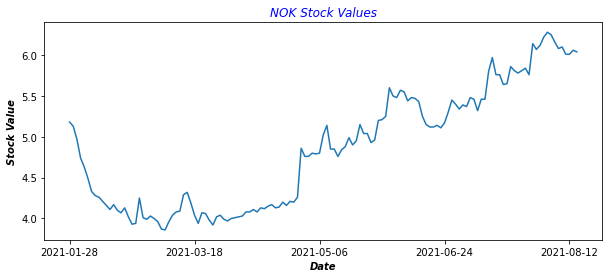

In [154]:
#@title Stocks value over time
stock_date_show(GME_stocks_df, "GME")
stock_date_show(AMC_stocks_df, "AMC")
stock_date_show(NOK_stocks_df, "NOK")

First observation is that all 3 stocks had at list one segnificant event (dramatic price change) in our dates range.
It is important for our model, in order to be able to learn what social circumstances can cause or relate to such change.

The big story of GME short squeeze happend in January 2021, and our dataset starts at the end of the rapid increase. That is the reason for the big drop at the beginning of GME.
We are wondering rather to expand the dataset, so it contain the whole increase process of GME or to cut it so the it will start straight after it- We think that starting in the middle of the short squeeze might constitute a difficulty for our model to learn.

In [155]:
GME_df.sample()

,title,score,comms_num,body,timestamp,posts_day_count,PC,sentiment,Doc2Vec_title,Doc2Vec_body
12223,GME Apollo 10 vs GME Apollo 11,131,34,I will start by stating that my retard to auti...,2021-02-28,147,NaN,0,"[-0.009222758, -0.0054543386, -0.0036517822, -...","[-0.009628791, -0.0052562556, -0.0014664569, 0..."


In [156]:
#@title The data in numbers
for stock_df in stocks_df_list:
  print(f"{stock_df.name} stock:\n\t"
          f"- Number of posts: {len(stock_df)}\n\t"
          f"- Highest positive Price Change in a day: {round(stock_df['PC'].max(), 2)}\n\t"
          f"- Lowest negative Price Change in a day: {round(stock_df['PC'].min(), 2)}\n\t"
          f"- Highest post score: {stock_df['score'].max()}")


GME stock:
	- Number of posts: 15058
	- Highest positive Price Change in a day: 60.26
	- Lowest negative Price Change in a day: -91.56
	- Highest post score: 225870
AMC stock:
	- Number of posts: 5381
	- Highest positive Price Change in a day: 7.95
	- Lowest negative Price Change in a day: -5.69
	- Highest post score: 163278
NOK stock:
	- Number of posts: 1945
	- Highest positive Price Change in a day: 0.2
	- Lowest negative Price Change in a day: -0.57
	- Highest post score: 65165


In [282]:

stock_names = [stock.name for stock in stocks_df_list]
fig = make_subplots(rows=1, cols=3, subplot_titles=("Max Price Change", "Min Price Change", "Max Post Score"))

# pc max
fig.add_trace(
    go.Bar(x=stock_names, y=[stock_df['PC'].max() for stock_df in stocks_df_list], 
    marker_color=['mediumslateblue', 'lightgreen','lightcoral'],
     hovertemplate ='<i></i>%{y:.2f}<extra></extra>'),
    row=1, col=1
)

# pc min
fig.add_trace(
    go.Bar(x=stock_names, y=[stock_df['PC'].min() for stock_df in stocks_df_list], 
    marker_color=['mediumslateblue', 'lightgreen','lightcoral'],
     hovertemplate ='<i></i>%{y:.2f}<extra></extra>'),
    row=1, col=2
)

# score max
fig.add_trace(
    go.Bar(x=stock_names, y=[stock_df['score'].max() for stock_df in stocks_df_list], 
    marker_color=['mediumslateblue', 'lightgreen','lightcoral'],
     hovertemplate ='<i></i>%{y:.2f}<extra></extra>'),
    row=1, col=3
)

fig.update_layout(hovermode="closest",  showlegend=False)
fig.show()

Here we again that GME changes are more radical, for example in one day the stock value jumped in 60\$, while the maximum raise in NOK was 0.2\$.

In [180]:
#@title Number of posts per stock
dict_posts_num = {}
for stock_df in stocks_df_list:
  dict_posts_num[stock_df.name] = len(stock_df)
fig = px.pie(union_df, values=dict_posts_num, names=dict_posts_num.keys())
fig.update_traces(textinfo='label+value')
fig.update_layout(hovermode=False, title={'text':'Posts number per stock',
        'y':0.95,
        'x':0.49,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

GME has the largest numbers. More posts, bigger changes in stock value and higher max score. Then comes AMC and then NOK.

Therefor, we should analyze and measure each stock according to itself, and not to set general thresholds and limits that applies to all stocks.

###Price changes distribution

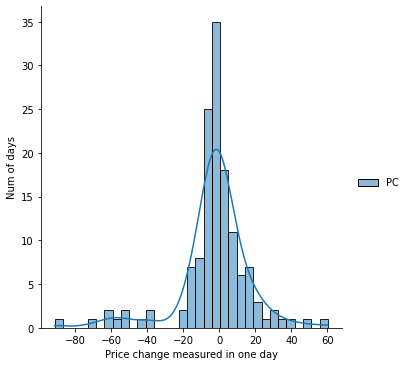

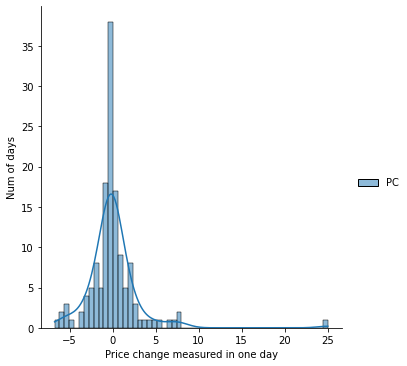

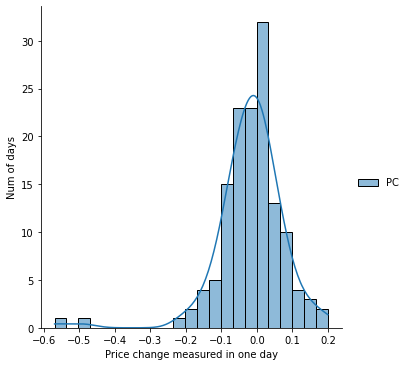

In [158]:
sns.displot(GME_label_df, kde=True).set_axis_labels("Price change measured in one day", "Num of days")
sns.displot(AMC_label_df, kde=True).set_axis_labels("Price change measured in one day", "Num of days")
sns.displot(NOK_label_df, kde=True).set_axis_labels("Price change measured in one day", "Num of days")

We can see that in our 3 chosen stocks, the major changes have been in the GME stock values- it has changes of over 40\$ in one day (and up to -90\$), while the largest change in AMC was 25\$, and for NOK -0.55\$.
We can learn that GME stock "acts" radically, and we should be espesially carful and cautious while analyzing it.

In [159]:
#@title Analyzing pairwise relationships between features
fig = px.scatter_matrix(union_day_df, dimensions=["score", "comms_num", "posts_day_count", "sentiment"], color='stock_name', hover_data=["timestamp"])
fig.show()

We can infer few conclusions from the graphs above:


*   As we saw before- GME stock had "more from everything" than AMC and NOK (more posts, total scores..).
*   There are few single days that have an extra ordinary data, like a huge number of comments or a big total scores number. Adding the date to each label reveal that they were part of the big *short squeeze* that happened in the end of January 2021.
*   From the sentiment graphs- usually the sentiment of days with a large total sentiment value  is positive. That is, when there are many posts or many comments for posts, usually it goes with a positive post.

###Normalized Sentiment VS Value

we see a partly correlation between the normalized sentiment and price changes

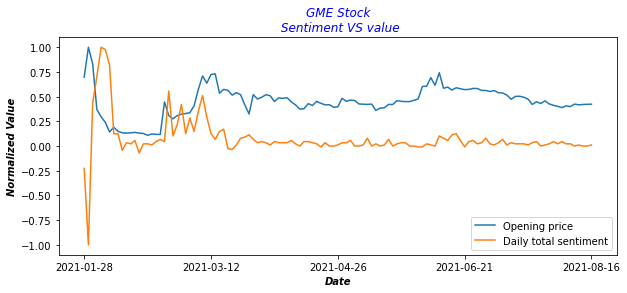

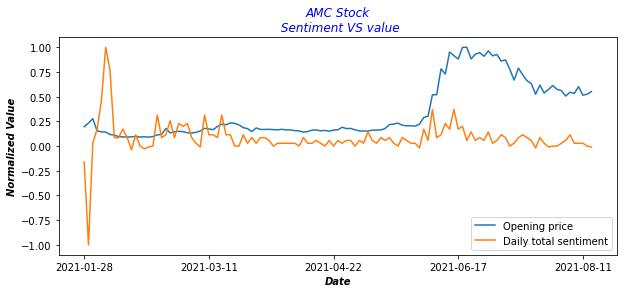

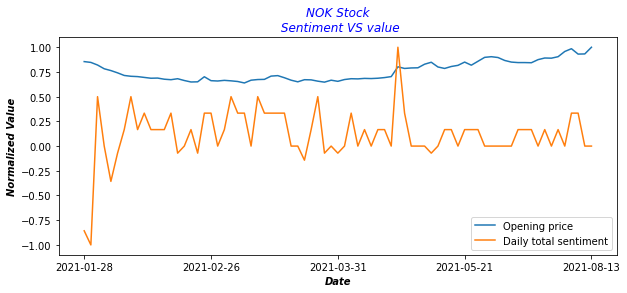

In [160]:
normialized_sentiment_value_show(GME_df, GME_stocks_df, "GME")
normialized_sentiment_value_show(AMC_df, AMC_stocks_df, "AMC")
normialized_sentiment_value_show(NOK_df, NOK_stocks_df, "NOK")

We can see that significant price increasments in GME and AMC (blue curve) are usually accompanied by a strong positive sentiment, and the big drop in GME at the beginning of February 2021 was accompanied by a strong negative sentiment.

In contrast- NOK stock value seems to be more insensitive to sentiments, even though the sentiment differents are less radical. The strongest sentiment for NOK does accompanied by a small value increasment.

###Amount of posts per stock

First we'll plot a violin graph of each stock for the whole period:

In [161]:
#@title Violin Graph
fig = go.Figure()

for stock_df in [day_GME_df, day_AMC_df, day_NOK_df]:
  fig.add_trace(go.Violin(y=stock_df['posts_day_count'],
                          name=stock_df.name,
                          box_visible=True,
                          meanline_visible=True))

fig.show()

In [162]:
#@title Violin Graph from day 10
fig = go.Figure()

for stock_df in [day_GME_df, day_AMC_df, day_NOK_df]:
  fig.add_trace(go.Violin(y=stock_df['posts_day_count'][100:],
                          name=stock_df.name,
                          box_visible=True,
                          meanline_visible=True))

fig.show()

We can see that out data starts with a very radical situation, where the nuber of comments is very high, and after 10 days the distribution is getting normal again.

###Semantic Distribution

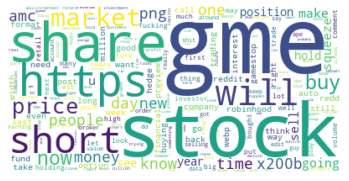

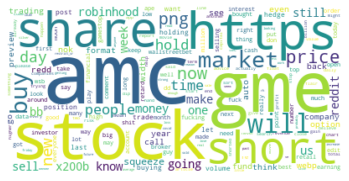

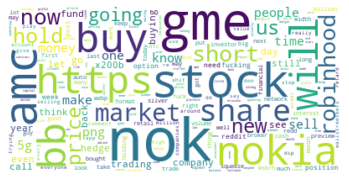

In [163]:
create_wordclouds([GME_df, AMC_df, NOK_df])

Looking at the most common words, we can see that most of them are neutral, and some are even not related to the post saying (like 'http' and 'png').

We cannot say rather we should consider the sentiment feature as a main feature for predicting value change or not, but it worth to test the effect of the post's nerative on our results mainly when it's a strong one- means that in one day, many posts had a clear strong sentiment.

In [164]:
# FreqDist(word.lower() for word in word_tokenize(final_text)).plot(20, cumulative=True)

##Brute Force Algorithms

### Analitical Regressions

First, we used linear and logistic regression to analyze the connection between the features and the stock's price change. 

#### Linear Regression

#####First Model

We started with a simple linear regression model:

$PC_{day_{i+1}}= α_0*score_{day_i}+α_1*comms_{day_i}+α_2*posts_{day_i}+α_3*sentiment_{day_i}$


while:

* $score_{day_i}$ : sum of scores of all posts in day i over GME in r/wallstreetbets channel. the score of a post is determined by the number of upvotes (likes) minus the number of downvots (dislikes) upon the post .

* $comms_{day_i}$ : sum of all the comments over all the posts in day i over GME in r/wallstreetbets channel

* $posts_{day_i}$ : number of posts posted in day i over GME in r/wallstreetbets channel

* $sentiment_{day_i}$ : sum of all sentiments score determined by VADER of posts posted in day i over GME in r/wallstreetbets 

* $PC_{day_{i+1}}$ : Price changes (open - close) in the GME stock's value on day i+1 (predicted variable)




In [165]:
linear_df = day_before.dropna().copy(deep=True)
linear_df.drop(['timestamp'], axis=1, inplace=True)
model = sm.OLS(linear_df['PC'],linear_df.drop(['PC'], axis=1))
results = model.fit()
results.params
r = np.ones_like(results.params)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                     PC   R-squared (uncentered):                   0.264
Model:                            OLS   Adj. R-squared (uncentered):              0.238
Method:                 Least Squares   F-statistic:                              10.39
Date:                Tue, 14 Jun 2022   Prob (F-statistic):                    3.17e-07
Time:                        10:26:50   Log-Likelihood:                         -510.61
No. Observations:                 120   AIC:                                      1029.
Df Residuals:                     116   BIC:                                      1040.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
score           -5.872e-05   1.28e-05     -4.588      0.000   -8.41e-05   -3.34e-05
comms_num           0.0002   6.52e-05      2.608      0.010    4.09e-05       0.000
posts_day_count    -0.0204      0.008     -2.442      0.016      -0.037      -0.004
sentiment           0.5050      0.185      2.725      0.007       0.138       0.872
==============================================================================
Omnibus:                       17.325   Durbin-Watson:                   2.303
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               75.089
Skew:                          -0.119   Prob(JB):                     4.95e-17
Kurtosis:                       6.868   Cond. No.                     3.21e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.21e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

We can see high levels of significance in both t values and F values. Therefore, the features have a high probability of being relevant for the predictions. But, the $R^2$ score is 0.264 which is low. So, the simple model isn't complex enough to predict the PC with efficient accuracy. To improve accuracy, we will try a more complex model with more features.


#####second model

$PC_{day_{i+1}}=α_0*score_{day_i}+α_1*comms_{day_i}+α_2*posts_{day_i}+α_3*sentiment_{day_i}+α_4*score_{day_i}*sentiment_{day_i}+α_5*comms_{day_i}*sentiment_{day_i}+α_6*posts_{day_i}*sentiment_{day_i}+α_7*posts_{day_i}^2+α_8*sentiment_{day_i}^2+α_9*score_{day_i}^2+α_{10}*comms_{day_i}^2$

We added interactions between every two initial features and polyinomial features to each feature in order to allow the model to integrate interactions between features and polynomial effects. 

In [166]:
linear_df['sentiment*score'] = linear_df['sentiment']*linear_df['score']
linear_df['sentiment*comms_num'] = linear_df['sentiment']*linear_df['comms_num']
linear_df['posts_day_count*sentiment'] = linear_df['posts_day_count']*linear_df['sentiment']
linear_df['posts_day_count**2'] = linear_df['posts_day_count']**2
linear_df['sentiment**2'] = linear_df['sentiment']**2
linear_df['score**2'] = linear_df['score']**2
linear_df['comms_num**2'] = linear_df['comms_num']**2

model = sm.OLS(linear_df['PC'],linear_df.drop(['PC'], axis=1))
results = model.fit()
results.params
r = np.ones_like(results.params)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                     PC   R-squared (uncentered):                   0.357
Model:                            OLS   Adj. R-squared (uncentered):              0.292
Method:                 Least Squares   F-statistic:                              5.502
Date:                Tue, 14 Jun 2022   Prob (F-statistic):                    6.17e-07
Time:                        10:26:50   Log-Likelihood:                         -502.48
No. Observations:                 120   AIC:                                      1027.
Df Residuals:                     109   BIC:                                      1058.
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
score                       2.89e-05    3.3e-05      0.876      0.383   -3.65e-05    9.43e-05
comms_num                  3.779e-05      0.000      0.268      0.789      -0.000       0.000
posts_day_count               0.0020      0.023      0.087      0.930      -0.043       0.047
sentiment                    -1.0229      0.575     -1.780      0.078      -2.162       0.116
sentiment*score            -1.68e-06   3.03e-06     -0.554      0.581   -7.69e-06    4.33e-06
sentiment*comms_num        8.063e-06   5.81e-06      1.387      0.168   -3.46e-06    1.96e-05
posts_day_count*sentiment     0.0012      0.001      1.700      0.092      -0.000       0.003
posts_day_count**2        -5.126e-05   2.32e-05     -2.210      0.029   -9.72e-05   -5.29e-06
sentiment**2                  0.0141      0.014      1.033      0.304      -0.013       0.041
score**2                  -2.032e-11   6.66e-11     -0.305      0.761   -1.52e-10    1.12e-10
comms_num**2              -2.547e-10   8.79e-10     -0.290      0.772      -2e-09    1.49e-09
==============================================================================
Omnibus:                       27.475   Durbin-Watson:                   2.317
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              125.595
Skew:                          -0.595   Prob(JB):                     5.34e-28
Kurtosis:                       7.869   Cond. No.                     1.20e+11
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.2e+11. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In terms of statistical significance, the F value is still significant within a confidence interval of 95%. So, the model is relevant for predicting PC value. But, the T value of every feature except the $posts^2$ is not high enough. So in terms of analysing the features, we can only assume that the influence of the number of posts in a day isn't linear. And, can't know the exact relevance of the other features in the model.
We can also see an improvement in the accuracy score ($R^2$) to 0.357 as we wanted to achieve.

####Logistic Regression

After getting maximum accuracy of 0.357 with the linear regression we turn to a logistic regression model. With it we can only classify to classes - negative, positive or natural PC value. So we are taking the second, more complax model, from before and change the predicted values into classes.

In [167]:
logistic_df = linear_df.copy(deep=True)
logistic_df['PC']= logistic_df['PC'].apply(lambda x: 'positive' if x>0 else 'negative' if x<0 else 'no change' if x==0 else None)
logistic_df.dropna(inplace=True)
x = logistic_df.drop(['PC'], axis=1)
y = logistic_df['PC']
clf = LogisticRegression(random_state=0).fit(x, y)
clf.score(x, y)

0.5666666666666667

We have a significant improvement in the accuracy score from the linear model (0.56 VS 0.357). Thus, simply classifying the trend in a stock's value is likely easier than trying to predict the exact price movements. 

###Classifiers

After using analitical regressions over the data we turn to use a classical simple classfiing algorithms:
* Random Forest (RF)
* k nearest neighbors (KNN)
* Support vector machine (SVM)

In order to let the algorithms extract features from the clean data frame, we return to the clean data frame with it classifying to classes version.

In [168]:
cls_df = day_before.dropna().copy(deep=True)
cls_df['PC']= cls_df['PC'].apply(lambda x: 'positive' if x>0 else 'negative' if x<0 else 'no change' if x==0 else None)
cls_df.drop(['timestamp'], axis=1, inplace=True)
cls_df.dropna(inplace=True)
x = cls_df.drop(['PC'], axis=1)
y = cls_df['PC']
cls_df.sample(n=4)

,score,comms_num,posts_day_count,PC,sentiment
26,140588,12396,268.0,positive,4
101,6610,1090,92.0,positive,0
34,287525,89821,589.0,positive,37
168,33,40,54.0,positive,0


In [169]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

####Random Forest

In [170]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
rfc.score(X_test, y_test)

0.625

####SVM

In [171]:
from sklearn import svm

clf = svm.SVC(kernel="rbf", C=1, probability=True)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.625

####KNN

In [172]:
knn = KNeighborsClassifier(5)
knn.fit(X_train, y_train)
knn.score(X_test, y_test)

0.75

We are getting the highest score with KNN (o.75 VS 0.625 and 0.542).

####KNN  roc and report:

To learn more about the problem, we are analyzing the most accurate classifier results (KNN):



In [173]:
y_pred = knn.predict(X_test)
knn_cf_matrix, knn_cl_report, knn_acc_score = get_metrices(y_test,y_pred)
print(knn_cl_report)

              precision    recall  f1-score   support

    negative       0.85      0.73      0.79        15
    positive       0.64      0.78      0.70         9

    accuracy                           0.75        24
   macro avg       0.74      0.76      0.74        24
weighted avg       0.77      0.75      0.75        24



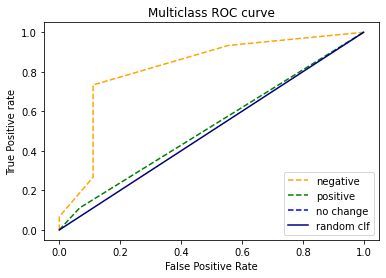

<Figure size 640x480 with 0 Axes>

In [174]:
roc_curve_PC(knn, X_train, y_train)

We can see that the algorithm can predict with more precision negative trends in the stock price than positive ones. 
This can suggest a stronger relationship between a decrease in stock value and the reddit posts than an increase in stock value. But, it could also be connected to the fact that our database is limited to a specific period and specifically lacks the initiation of the GME frenzy.ueese.

##Conclusion

In this Project Suggestion, we discussed the connections between trends on the social media platform - Reddit and specific stocks values. 
We used a premade Kaggle dataset and processed it to our needs by hard-coded actions and premade libraries such as VADER. 
We defined the question we intend to investigate - **whether we can predict the value of the stock tomorrow based on today's data** 

We applied some classical algorithms to the data in order to show that the connection may be causal or at least correlative.

As a result, we plan to continue to study it in our project. 
This will enable us to have a better grasp of the connections in our question field and to get better accurate results

###Looking forward to the project:
we intend to do the following:

*   using the data from all the 3 stocks for the classification
*   trying deep neural network over the VADER sentiment and the Doc2Vec vectors
*   augmenting the dataset by Reddit API - specifically to the period before the GME's short squeeze. As we mentioned, our data from kaggle starts in the middle of the big hype of the Meme-Stocks, and for that reason it is many times distorted for predictions. In some cases it is better to skip the first days of sampling to get a more stable prediction.
*   extracting more features from the links, photos, and videos from the posts
*   adding more stocks than GME, AMC, and NOK

